In [1]:
#!git clone https://github.com/FedericoArcelaschi-Polimi/edited_RecSyS_Course_AT_PoliMi

In [2]:
#cd edited_RecSyS_Course_AT_PoliMi

In [3]:
import numpy as np
import matplotlib.pyplot as pyplot
import pandas as pd
import scipy.sparse as sps
%matplotlib inline  
%load_ext Cython

from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.NonPersonalizedRecommender import TopPop
import optuna

import xgboost as xgb
from xgboost import XGBRanker, plot_importance

C:\Users\feder\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#!pip install pymysql

In [5]:
# data_train_path="/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv"
# data_target_user_path="/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv"
data_train_path="data_train.csv"
data_target_user_path="data_target_users_test.csv"
data_train = pd.read_csv(data_train_path)
data_target = pd.read_csv(data_target_user_path)

In [6]:
URM_all =  data_train.pivot(index='row', columns='col', values='data').fillna(0)
item_map = {i : item for i, item in enumerate(URM_all.columns)}
user_map = {i : user for i, user in enumerate(data_target["user_id"])}
item_map_inv = {item : i for i, item in item_map.items()}
user_map_inv = {user : i for i, user in user_map.items()}
missing_index = [x for x in range(1,13025) if x not in URM_all.index.tolist()]
add_urm = pd.DataFrame(index = missing_index, columns = URM_all.columns).fillna(0)
URM_all = pd.concat([URM_all, add_urm]).sort_index()
del add_urm
del missing_index
URM_all = URM_all.to_numpy()
URM_all = sps.csr_matrix(URM_all)
URM_all

<13024x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [7]:
# test_folds = 10
# train_percentages = [0] * test_folds
# for i in range(test_folds):
#     train_percentages[i] = (test_folds-1-i)/(test_folds-i)
# URM_trains = [None] * test_folds
# URM_tests = [None] * test_folds
# evaluator_tests = [None] * test_folds
# for i in range(test_folds):
#     if i == 0:
#         URM_trains[i], URM_tests[i] = split_train_in_two_percentage_global_sample(URM_all, train_percentage = train_percentages[i])
#     else:
#         URM_trains[i], URM_tests[i] = split_train_in_two_percentage_global_sample(URM_trains[i-1], train_percentage = train_percentages[i])
#     evaluator_tests[i] = EvaluatorHoldout(URM_tests[i], cutoff_list=[10])
# for i in range(test_folds):
#     URM_trains[i] = URM_all - URM_tests[i]

#URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2563 (19.7%) Users that have less than 1 test interactions


In [8]:
from Recommenders.BaseRecommender import BaseRecommender

class ScoresHybridRecommender(BaseRecommender):

    RECOMMENDER_NAME = "ScoresHybridRecommender"

    def __init__(self, URM_train, recommenders, verbose):

        super(ScoresHybridRecommender, self).__init__(URM_train, verbose=verbose)

        self.URM_train = sps.csr_matrix(URM_train)
        self.recommenders = recommenders
        
        
    def fit(self, weights):
        self.weights = weights

    def _compute_item_score(self, user_id_array, items_to_compute):
        
        # In a simple extension this could be a loop over a list of pretrained recommender objects
        
        item_weight_per_recommender = [None]*len(self.recommenders)
        for i, recommender in enumerate(self.recommenders):
            item_weight_per_recommender[i] = recommender._compute_item_score(user_id_array, items_to_compute)

        item_weights = item_weight_per_recommender[0]*self.weights[0]
        for i in range(1, len(self.recommenders)):
            item_weights += item_weight_per_recommender[i]*self.weights[i]

        return item_weights

In [9]:
# Replace the following with your MySQL database connection details
host = "db-mysql-recsys-do-user-15390069-0.c.db.ondigitalocean.com"
port = 25060
database_name = "optuna"
username = ""
password = ""

# Create an SQLAlchemy engine
mysql_url = f"mysql+pymysql://{username}:{password}@{host}:{port}/{database_name}"
mysql_url
storage = optuna.storages.RDBStorage(url=mysql_url)

nmf_name = "NMF10_DB"
knn_name = "itemKNN10_DB"
slim_name = "SLIM_EN10_DB"
rp3beta_name = "RP3b10_DB"
p3alpha_name = "P3a10_DB"
hybrid_name = "HYBRID10_DB"
nmf_study = optuna.load_study(study_name=nmf_name, storage=storage)
knn_study = optuna.load_study(study_name=knn_name, storage=storage)
slim_study = optuna.load_study(study_name=slim_name, storage=storage)
rp3beta_study = optuna.load_study(study_name=rp3beta_name, storage=storage)
p3alpha_study = optuna.load_study(study_name=p3alpha_name, storage=storage)
hybrid_study = optuna.load_study(study_name=hybrid_name, storage=storage)

studies = [nmf_study, knn_study, slim_study, rp3beta_study, p3alpha_study]
recommenders_list = ["Hybrid", "itemKNN", "RP3beta", "P3alpha", "NMF", "SLIM_EN", "TopPop"]

In [10]:
%%time
item_knn_recommender = ItemKNNCFRecommender(URM_train, verbose=False)
RP3beta_recommender = RP3betaRecommender(URM_train, verbose=False)
P3alpha_recommender = P3alphaRecommender(URM_train, verbose=False)
SLIM_EN_recommender = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train, verbose=False)
NMF_recommender = NMFRecommender(URM_train, verbose=False)
TopPop_recommender = TopPop(URM_train)
print("ITEMKNN...")
item_knn_recommender.fit(shrink=knn_study.best_params["shrink"], topK=knn_study.best_params["topK"])
print("RP3BETA...")
RP3beta_recommender.fit(alpha=rp3beta_study.best_params["alpha"], beta=rp3beta_study.best_params["beta"], topK=rp3beta_study.best_params["topK"])
print("P3ALPHA...")
P3alpha_recommender.fit(topK=p3alpha_study.best_params["topK"], alpha=p3alpha_study.best_params["alpha"])
print("SLIM...")
SLIM_EN_recommender.fit(workers=12,topK=slim_study.best_params["topK"], l1_ratio=slim_study.best_params["l1_ratio"], alpha=slim_study.best_params["alpha"], verbose=False)
print("NMF...")
NMF_recommender.fit(num_factors = nmf_study.best_params["factors"], l1_ratio = nmf_study.best_params["l1_ratio"], init_type = nmf_study.best_params["init"], beta_loss = nmf_study.best_params["beta_loss"])
print("TopPop...")
TopPop_recommender.fit()

recommenders = {
    "SLIM_EN" : SLIM_EN_recommender,
    "RP3beta" : RP3beta_recommender,
    "itemKNN" : item_knn_recommender,
    "P3alpha" : P3alpha_recommender,
    "NMF" : NMF_recommender,
}
print("HYBRID...")
hybrid_recommender = ScoresHybridRecommender(URM_train, recommenders.values(), verbose=False)
hybrid_recommender.fit([hybrid_study.best_params['weight_{}'.format(i) ] for i, study in enumerate(studies)])

recommenders["TopPop"] = TopPop_recommender
recommenders["Hybrid"] = hybrid_recommender

TopPopRecommender: URM Detected 601 ( 4.6%) users with no interactions.
TopPopRecommender: URM Detected 103 ( 0.5%) items with no interactions.
ITEMKNN...
Similarity column 22222 (100.0%), 8081.81 column/sec. Elapsed time 2.75 sec
RP3BETA...
P3ALPHA...
SLIM...
NMF...
TopPop...
HYBRID...


AttributeError: 'dict' object has no attribute 'add'

In [231]:
recommenders_tuple = [(recommenders_list[i], study.best_value, recommenders[recommenders_list[i]]) for i, study in enumerate(studies)]
# sort studies by best value
recommenders_tuple.append(("TopPop", 0.0, TopPop_recommender))
recommenders_tuple.sort(key=lambda x: x[1], reverse=True)
recommenders_tuple

[('P3alpha',
  0.0300424519886685,
  <Recommenders.GraphBased.P3alphaRecommender.P3alphaRecommender at 0x134a473bed0>),
 ('NMF',
  0.028691217270341306,
  <Recommenders.MatrixFactorization.NMFRecommender.NMFRecommender at 0x13600887f50>),
 ('RP3beta',
  0.025966694210683806,
  <Recommenders.GraphBased.RP3betaRecommender.RP3betaRecommender at 0x135ee5894d0>),
 ('SLIM_EN',
  0.025143288853953664,
  <Recommenders.SLIM.SLIMElasticNetRecommender.MultiThreadSLIM_SLIMElasticNetRecommender at 0x135ee5da4d0>),
 ('itemKNN',
  0.018809431530436092,
  <Recommenders.KNN.ItemKNNCFRecommender.ItemKNNCFRecommender at 0x1360d08d990>),
 ('TopPop',
  0.0,
  <Recommenders.NonPersonalizedRecommender.TopPop at 0x135fb17e6d0>)]

In [ ]:
main_recommender = "SLIM_EN"
xgboost_values = []
suggestions, scores_MAIN = recommenders[main_recommender].recommend(data_target["user_id"]-1, cutoff=30, return_scores=True)
other_list = [recommender for recommender in recommenders_list if recommender != main_recommender]
scores_others = {}
for i, recommender in enumerate(other_list):
    _, scores_others[recommender] = recommenders[recommender].recommend(data_target["user_id"]-1, cutoff=30, return_scores=True)
for i, suggestion in enumerate(suggestions):
    for item_id in suggestion:
        xgboost_values.append([data_target["user_id"][i], item_map[item_id], URM_validation[data_target["user_id"][i]-1,item_id] == 1,scores_MAIN[i][item_id]]+[scores_others[other][i][item_id] for other in other_list])
toppop_items, scores_toppop = recommenders["TopPop"].recommend(1, cutoff=30, return_scores=True)
xgboost_df = pd.DataFrame(xgboost_values,columns=["user_id", "item_id", "label", main_recommender]+other_list)

xgboost_df[xgboost_df["user_id"] == 65]

In [ ]:
xgboost_df[xgboost_df["user_id"] == 7]

,user_id,item_id,label,SLIM_EN,itemKNN,RP3beta,P3alpha,NMF,TopPop


In [117]:
xgboost_df.where(xgboost_df["label"] == 1).dropna()

,user_id,item_id,label,SLIM_EN,itemKNN,RP3beta,P3alpha,NMF
10,1.0,429.0,True,0.189960,0.632268,0.108604,0.044457,0.083381
11,1.0,879.0,True,0.162939,0.183540,0.135350,0.089179,0.009996
32,2.0,1.0,True,0.263885,0.204867,0.093699,0.077902,0.001658
90,4.0,17.0,True,0.443727,1.451927,0.370449,0.404758,0.006971
91,4.0,252.0,True,0.408945,0.781131,0.228372,0.139479,0.362863
...,...,...,...,...,...,...,...,...
326427,13023.0,624.0,True,0.081029,0.336721,0.000000,0.000000,0.075534
326440,13024.0,10204.0,True,0.310888,1.560122,0.264720,0.073445,0.100876
326447,13024.0,606.0,True,0.260700,0.771557,0.231184,0.091793,0.208222
326448,13024.0,1006.0,True,0.259481,0.551072,0.177780,0.083203,0.012797


In [118]:
n_estimators = 50
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      enable_categorical = True,
                      )

In [119]:
y_train = xgboost_df["label"]
X_train = xgboost_df.drop(columns=["label"])
X_train_drop = xgboost_df.drop(columns=["label", "item_id", "user_id"])
#X_train["user_id"] = X_train["user_id"].astype("category")
#X_train["item_id"] = X_train["item_id"].astype("category")
groups = xgboost_df.groupby("user_id").size().values
XGB_model.fit(X_train_drop,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [215]:
X_to_predict = X_train_drop[X_train["user_id"] == 22]

scores = XGB_model.predict(X_to_predict)
scores

array([], shape=(0, 0), dtype=float32)

In [166]:
user_map_inv[13024]

10881

In [159]:
X_to_predict = X_train[X_train["user_id"] == 1]
item_scores = np.zeros(22348)
item_id_mapped = [item_map[i] for i in X_to_predict["item_id"]]
item_scores[item_id_mapped] = scores
item_scores[item_map[1338]], X_to_predict["item_id"]

(0.2763512432575226,
 0      101
 1       36
 2      515
 3      694
 4     1546
 5     1422
 6      592
 7      506
 8      403
 9      216
 10     429
 11     879
 12    1481
 13     618
 14       1
 15    1338
 16     314
 17     139
 18     977
 19    1288
 20     342
 21    1083
 22    1630
 23      60
 24     602
 25    1547
 26     102
 27     154
 28    6620
 29     303
 Name: item_id, dtype: int64)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

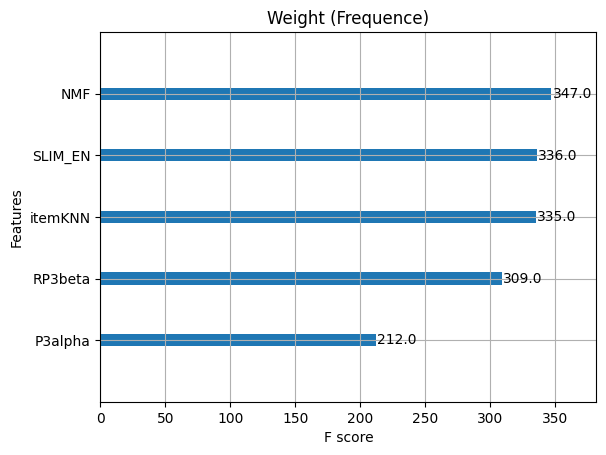

In [121]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [12]:
from Recommenders.BaseRecommender import BaseRecommender

class XGBoostRecommender(BaseRecommender):

    RECOMMENDER_NAME = "XGBoostRecommender"

    def __init__(self,
                URM_train,
                recommenders,
                main_recommender,
                verbose = True,
                n_estimators = 50,
                learning_rate = 1e-1,
                reg_alpha = 1e-1,
                reg_lambda = 1e-1,
                max_depth = 20,
                max_leaves = 0,
                grow_policy = "depthwise",
                objective = "pairwise",
                booster = "gbtree",
                random_seed = None,
                ):

        super(XGBoostRecommender, self).__init__(URM_train, verbose=verbose)

        self.XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                                n_estimators = int(n_estimators),
                                random_state = random_seed,
                                learning_rate = learning_rate,
                                reg_alpha = reg_alpha,
                                reg_lambda = reg_lambda,
                                max_depth = int(max_depth),
                                max_leaves = int(max_leaves),
                                grow_policy = grow_policy,
                                verbosity = 0, # 2 if self.verbose else 0,
                                booster = booster,
                                enable_categorical = True,
                            )
        self.recommenders = recommenders
        self.main_recommender = main_recommender
        self.X_train = None
        self.y_train = None
        
    def fit(self):
        xgboost_values = []
        suggestions, scores_MAIN = self.recommenders[self.main_recommender].recommend(data_target["user_id"]-1, cutoff=30, return_scores=True)
        other_list = [recommender for recommender in recommenders_list if recommender != self.main_recommender]
        scores_others = {}
        for i, recommender in enumerate(other_list):
            _, scores_others[recommender] = self.recommenders[recommender].recommend(data_target["user_id"]-1, cutoff=30, return_scores=True)
        for i, suggestion in enumerate(suggestions):
            for item_id in suggestion:
                xgboost_values.append([data_target["user_id"][i]-1, item_id, URM_validation[data_target["user_id"][i]-1,item_id] == 1,scores_MAIN[i][item_id]]+[scores_others[other][i][item_id] for other in other_list])
        
        # add top pop items to users with 0 label
        # toppop_items, scores_toppop = self.recommenders["TopPop"].recommend(1, cutoff=30, return_scores=True)
        # for user in data_target["user_id"]:
        #     xgboost_values.append([user, toppop_items+1, 0, 0]+[0 for other in other_list if other != "TopPop"]+[scores_toppop[0][item_map[item]] for item in toppop_items])
        
        xgboost_df = pd.DataFrame(xgboost_values,columns=["user_id", "item_id", "label", self.main_recommender]+other_list)

        self.y_train = xgboost_df["label"]
        self.X_train = xgboost_df.drop(columns=["label"])
        self.X_train["user_id"] = self.X_train["user_id"].astype("category")
        self.X_train["item_id"] = self.X_train["item_id"].astype("category")
        groups = xgboost_df.groupby("user_id").size().values
        self.XGB_model.fit(self.X_train,
                    self.y_train,
                    group=groups,
                    verbose=True)
    
    def get_URM_train(self):
        return self.URM_train

    def _compute_item_score(self, user_id_array, items_to_compute):
        item_weights = np.zeros((len(user_id_array), self.n_items))
        for i, user in enumerate(user_id_array):
            if user in data_target["user_id"].values-1:
                X_to_predict = self.X_train[self.X_train["user_id"] == user]
                scores = self.XGB_model.predict(X_to_predict)
                scores = (scores - scores.min())/(scores.max() - scores.min() + 1e-12)
                item_weights[i][X_to_predict["item_id"]] = scores

        return item_weights

In [13]:
main_recommender = "Hybrid"
XGBoostRecommender = XGBoostRecommender(URM_train, recommenders, main_recommender)

XGBoostRecommender: URM Detected 601 ( 4.6%) users with no interactions.
XGBoostRecommender: URM Detected 103 ( 0.5%) items with no interactions.


In [14]:
XGBoostRecommender.fit()

MemoryError: Unable to allocate 922. MiB for an array with shape (10882, 22222) and data type float32

In [ ]:
XGBoostRecommender.X_train[XGBoostRecommender.X_train["user_id"] == 0]

In [398]:
#plot_importance(XGBoostRecommender.XGB_model, importance_type='weight', title='Weight (Frequence)')

In [400]:
evaluation_res = evaluator_validation.evaluateRecommender(XGBoostRecommender)

EvaluatorHoldout: Processed 10482 (100.0%) in 54.50 sec. Users per second: 192


In [401]:
evaluation_res[0]

,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.168823,0.259664,0.207566,0.166033,0.256228,0.62453,0.338491,0.1862,0.626884,0.98549,...,0.804822,0.50453,0.804822,0.044584,9.82538,0.99719,0.127975,0.75688,1.81619,0.301498
